In [1]:
from time import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
sns.set_theme(style="darkgrid")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [3]:
def calc_rps(predictions, observed):
    """Vectorized version of Ranked Probability Score.
    A lower value is a better score.
    From: Colin Catlin, https://syllepsis.live/2022/01/22/ranked-probability-score-in-python/

    Args:
        predictions (pd.DataFrame): each column is an outcome category
            with values as the 0 to 1 probability of that category
        observed (pd.DataFrame): each column is an outcome category
            with values of 0 OR 1 with 1 being that category occurred
    """
    assert (
        predictions.shape == observed.shape
    ), "prediction and observed array shapes must match"
    ncat = predictions.shape[1] - 1
    return (
        np.sum(
            (np.cumsum(predictions, axis=1) - np.cumsum(observed, axis=1)) ** 2, axis=1
        ) / ncat
    )

In [4]:
knn_clf = KNeighborsClassifier(algorithm="kd_tree")
mlp_clf = MLPClassifier(hidden_layer_sizes=(512, 256, 64, 16), activation="relu", solver="sgd", max_iter=500)
gb_clf = GradientBoostingClassifier(n_estimators=200)
nb_clf = GaussianNB()

In [5]:
# cambiar el path para generar resultados de otro dataset
df = pd.read_csv("../datasets/x5.csv", index_col=0)
df.drop(labels=["match_api_id"], axis=1, inplace=True)

In [6]:
features = df.drop(labels=["label"], axis=1)
labels = df.loc[:, "label"]

In [7]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3)

In [8]:
models = {
    "KNN": knn_clf,
    "MLP": mlp_clf,
    "NB": nb_clf,
    "GB": gb_clf
}

preds = {}

In [9]:
for model_name, model in models.items():
    print(f"Entrenando {model_name}...")
    start = time()

    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(x_train, y_train)

    end = time()
    print("Entrenamiento de {} finalizado en {:.2f} minutos.".format(model_name, (end - start) / 60))

    print(f"Prediciendo con {model_name}...")
    start = time()

    preds[model_name] = dict()
    preds[model_name]["labels"] = pipe.predict(x_test)
    preds[model_name]["probs"] = pipe.predict_proba(x_test)

    end = time()
    print("Predicciones de {} hechas en {:.2f} segundos.".format(model_name, (end - start)))

Entrenando KNN...
Entrenamiento de KNN finalizado en 0.00 minutos.
Prediciendo con KNN...
Predicciones de KNN hechas en 53.80 segundos.
Entrenando MLP...
Entrenamiento de MLP finalizado en 9.79 minutos.
Prediciendo con MLP...
Predicciones de MLP hechas en 0.15 segundos.
Entrenando NB...
Entrenamiento de NB finalizado en 0.00 minutos.
Prediciendo con NB...
Predicciones de NB hechas en 0.06 segundos.
Entrenando GB...
Entrenamiento de GB finalizado en 0.97 minutos.
Prediciendo con GB...
Predicciones de GB hechas en 0.09 segundos.


In [10]:
observed_props = pd.get_dummies(y_test)

In [11]:
results_rps = {}
results_matrices = {}

In [12]:
for model_name, results in preds.items():
    results_rps[model_name] = calc_rps(results["probs"], observed_props).mean()
    results_matrices[model_name] = confusion_matrix(y_test, preds[model_name]["labels"])

<AxesSubplot:>

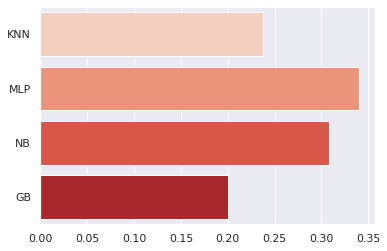

In [23]:
plot_df = pd.DataFrame(columns=preds.keys(), index=None)
for model_name in preds.keys():
    plot_df[model_name] = [results_rps[model_name]]
sns.barplot(data=plot_df, orient='h', palette='Reds')

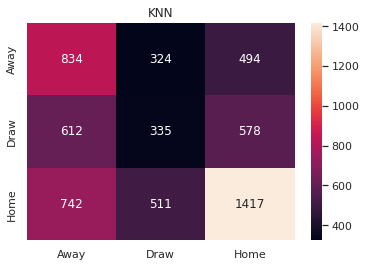

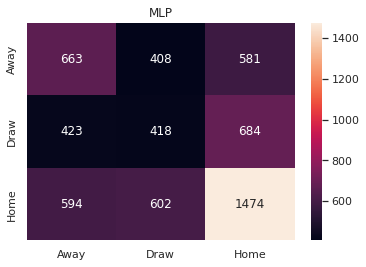

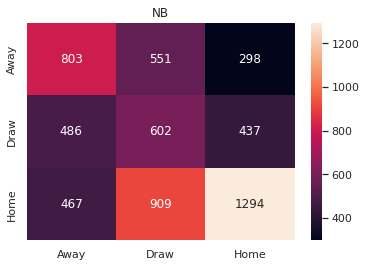

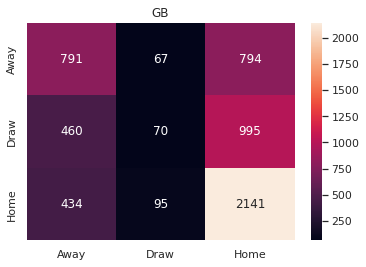

In [40]:
for model_name, matrix in results_matrices.items():
    sns.heatmap(
        data=results_matrices[model_name], 
        annot=True, 
        fmt='g', 
        xticklabels=["Away", "Draw", "Home"], 
        yticklabels=["Away", "Draw", "Home"],
    ).set_title(model_name)
    plt.show()